# Imports

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin
import seaborn as sns

In [2]:
# import data
df = pd.read_csv('raw-polls.csv')

# Analysis

## Sample Size

In [11]:
# mean error of all polls
df['error'].mean()

5.487316775599123

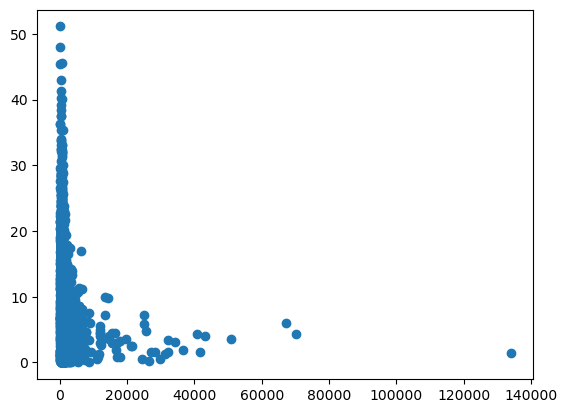

In [13]:
# polling error by sample size
plt.scatter('samplesize', 'error', data=df)

Text(0, 0.5, 'Poll Bias')

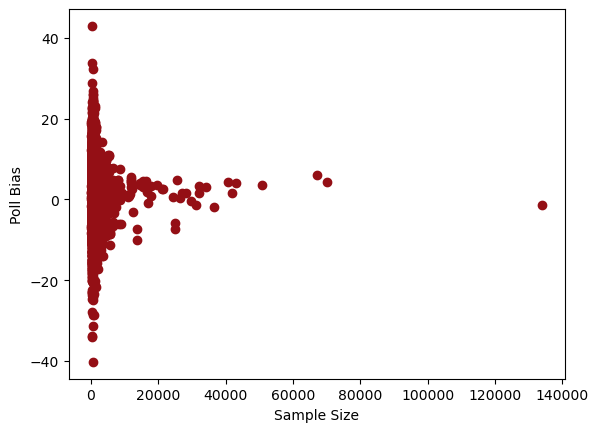

In [14]:
# bias (non absolute error) by sample size
plt.scatter('samplesize', 'bias', data=df[df['samplesize'] > 0], color='#940f15')
plt.xlabel("Sample Size")
plt.ylabel("Poll Bias")

Text(0, 0.5, 'Poll Bias')

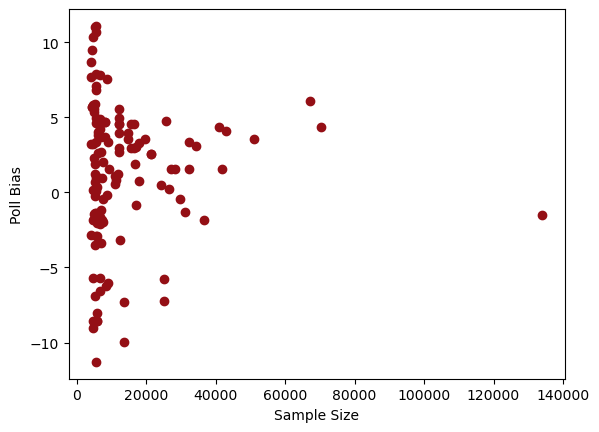

In [15]:
# bias (non absolute error) by sample size for polls with n > 4000
plt.scatter('samplesize', 'bias', data=df[df['samplesize'] > 4000], color='#940f15')
plt.xlabel("Sample Size")
plt.ylabel("Poll Bias")

Text(0, 0.5, 'Poll Bias')

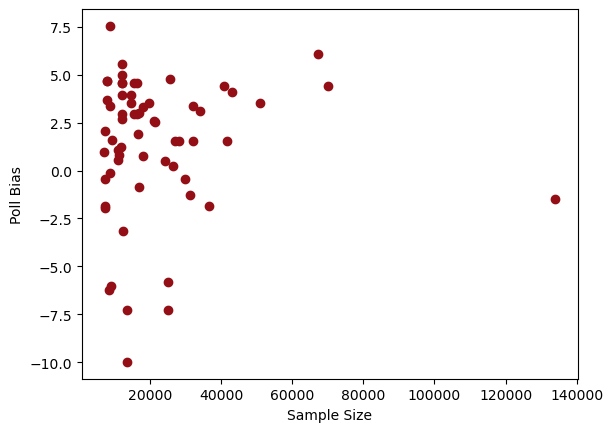

In [17]:
# bias (non absolute error) by sample size for polls with n > 7000
plt.scatter('samplesize', 'bias', data=df[df['samplesize'] > 7000], color='#940f15')
plt.xlabel("Sample Size")
plt.ylabel("Poll Bias")

Following what we would expect from statistical theory, the variation in error decreases as sample size increases. We find that polls with sufficiently large sample sizes are generally reliable and do not have outliers in error rate.

The mean error of all polls is 5.49, but at the low sample sizes there are huge outliers going up to an error of 40 points. However, for polls with a sample size > 4,000 the maximum error is below 12 points, and for polls with a sample size > 7,000 the maximum error is below 10 points.

## Polling Methods

In [6]:
# Find mean error and count for each methodology
methods_df = pd.DataFrame(df.groupby(["methodology"], as_index= False)['error'].agg(['mean', 'count']))
methods_df[methods_df['count'] > 50].sort_values('mean')

,mean,count
methodology,,
IVR/Online,5.046882,667
IVR/Live Phone,5.348261,161
IVR,5.448629,2574
Live Phone,5.507159,5762
Online,5.553222,1890
IVR/Text,6.392840,81
Live Phone/Online,7.154468,141


In [7]:
# ANOVA test by simple methodology
stats.f_oneway(df['error'][df['methodology'] == 'Online'],
               df['error'][df['methodology'] == 'IVR'],
               df['error'][df['methodology'] == 'Live Phone'])

F_onewayResult(statistic=0.26163588944942945, pvalue=0.769796416179281)

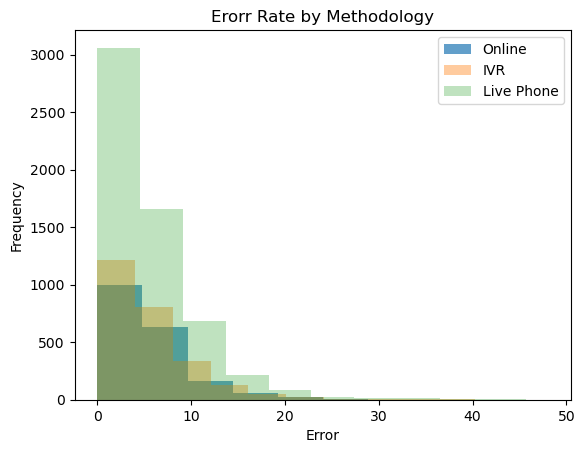

In [8]:
# Distributions of online, IVR, and live phone methods
plt.hist(df['error'][df['methodology'] == 'Online'], alpha = 0.7, label = "Online")
plt.hist(df['error'][df['methodology'] == 'IVR'], alpha = 0.4, label = "IVR")
plt.hist(df['error'][df['methodology'] == 'Live Phone'], alpha = 0.3, label = "Live Phone")

plt.legend(loc='upper right')
plt.title("Erorr Rate by Methodology")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

In [9]:
# ANOVA tests with all methodologies with greater than 50 samples
stats.f_oneway(df['error'][df['methodology'] == 'Online'],
               df['error'][df['methodology'] == 'IVR'],
               df['error'][df['methodology'] == 'Live Phone'],
               df['error'][df['methodology'] == 'IVR/Online'],
               df['error'][df['methodology'] == 'IVR/Live Phone'],
               df['error'][df['methodology'] == 'IVR/Text'],
               df['error'][df['methodology'] == 'Live Phone/Online']
)

F_onewayResult(statistic=4.244838836749526, pvalue=0.0002823973384326196)

In [10]:
# Repeat of last ANOVA test, less Live Phone/Online
stats.f_oneway(df['error'][df['methodology'] == 'Online'],
               df['error'][df['methodology'] == 'IVR'],
               df['error'][df['methodology'] == 'Live Phone'],
               df['error'][df['methodology'] == 'IVR/Online'],
               df['error'][df['methodology'] == 'IVR/Live Phone'],
               df['error'][df['methodology'] == 'IVR/Text']
               #df['error'][df['methodology'] == 'Live Phone/Online']
)

F_onewayResult(statistic=1.8190172435117578, pvalue=0.10542728708752853)

Amongst methodologies with at least 50 polls, there is no statistically significant different in mean error, except that the mean error for Live Phone/Online hybrid polls is greater than the mean errors for other methods.

## Competitivenes

Text(0, 0.5, 'Error')

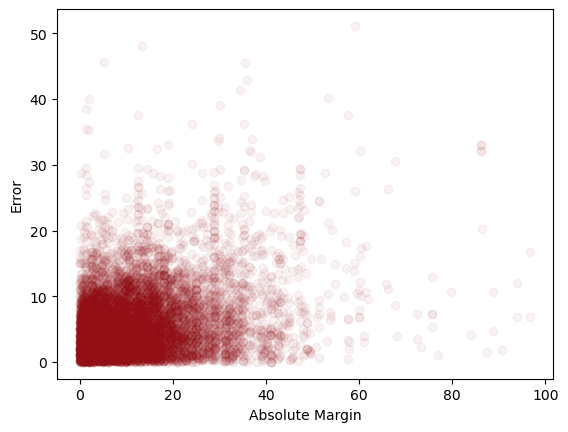

In [18]:
# polling error by the absolute margin in the actual election
plt.scatter(abs(df['margin_actual']), 'error', data=df, alpha=0.05, color='#940f15')
plt.xlabel('Absolute Margin')
plt.ylabel('Error')

Here we can see that there is no relation between the absolute margin and the error of the poll. This is not what we were expecting. I assumed that if a race was closer it would have less error, but that is not the case.

## Location

In [24]:
# create a new dataframe that looks at the average error and number of polls for all presidential elections
margin_df = df[df['type_simple'] == 'Pres-G'].groupby(['location'])['error'].agg(['mean', 'count']).reset_index()

# rename the columns to make them easier to understand
margin_df.columns = ['location', 'mean_error', 'count']

# sort by the mean error of the locations
margin_df = margin_df.sort_values('mean_error')

# exclude the national location from our analysis
margin_df = margin_df[margin_df['location'] != 'US']

In [25]:
# look at the 5 locations with the lowest error
margin_df.head()

,location,mean_error,count
10,GA,2.640417,72
49,VA,2.837653,98
29,N2,2.866667,6
51,WA,3.090698,43
5,CO,3.167470,83


In [26]:
# look at the 5 locations with the highest error
margin_df.tail()

,location,mean_error,count
31,ND,8.458462,13
13,ID,8.824545,11
54,WY,9.196667,9
7,DC,9.255000,4
11,HI,10.506000,10


We can see that all of the locations with the lowest error are typical battleground states. They are very competitive and often important to elections. Similarly, the locations with the highest error are states that have been historically insignificant in elections. Hawaii, DC, Wyoming, Idaho, and North Dakota always vote the same way, so their elections are less relevant. 

This suggests that the best polls are conducted in areas of high priority. That makes sense because the best pollsters will want to focus on areas that could shape the election, and those same areas also get the most political attention.

## Race Type

In [28]:
# Create tuple for each type of race
type_data =  df['error'][df['type_simple'] == 'Gov-G'], df['error'][df['type_simple'] == 'Sen-G'], df['error'][df['type_simple'] == 'House-G'], df['error'][df['type_simple'] == 'Pres-P'], df['error'][df['type_simple'] == 'Pres-G']

In [29]:
# Check the total number of each race
df["type_simple"].value_counts()

Pres-G     3004
Sen-G      2879
Gov-G      1963
Pres-P     1848
House-G    1781
Name: type_simple, dtype: int64

In [30]:
# Comparing mean error by type of race
mean_error_by_type_df = pd.DataFrame(df.groupby(["type_simple"], as_index= False)['error'].agg(['mean', 'count']))
mean_error_by_type_df.sort_values('mean')

,mean,count
type_simple,,
Pres-G,4.088938,3004
Gov-G,5.100015,1963
Sen-G,5.162553,2879
House-G,5.740309,1781
Pres-P,8.433972,1848


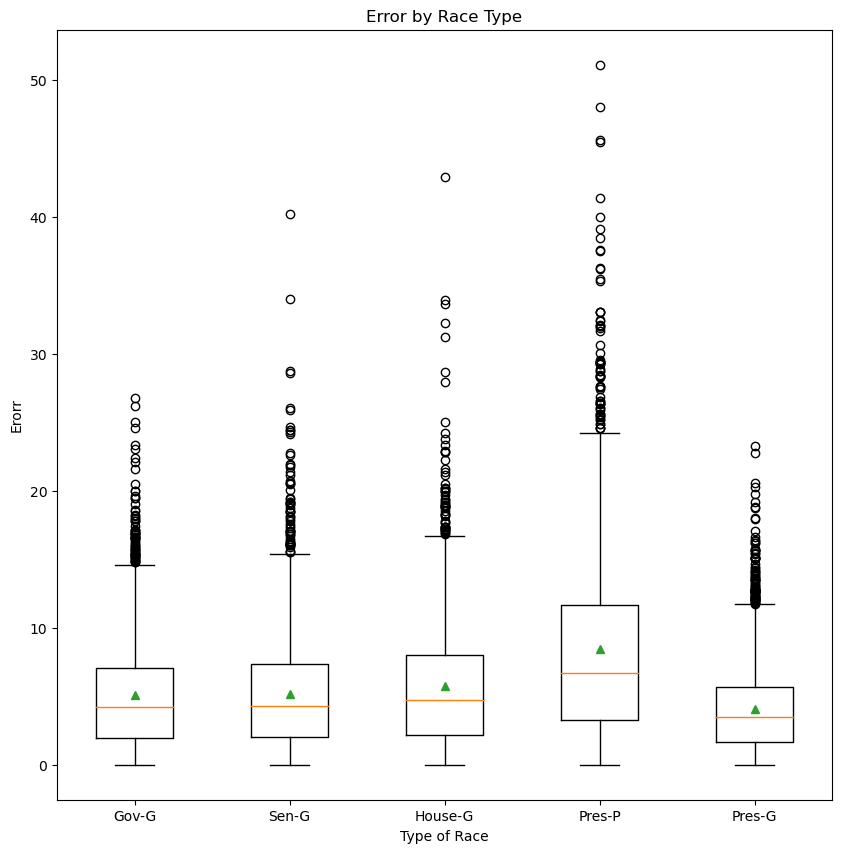

In [31]:
# Plot mean error by race type
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

ax.boxplot(type_data,
           labels = ['Gov-G', 'Sen-G', 'House-G', 'Pres-P', 'Pres-G'],
           showmeans = True)
plt.title("Error by Race Type")
plt.xlabel("Type of Race")
plt.ylabel("Erorr")
plt.show()

In [32]:
# ANOVA test for differences between race types
stats.f_oneway(df['error'][df['type_simple'] == 'Gov-G'],
               df['error'][df['type_simple'] == 'Sen-G'],
               df['error'][df['type_simple'] == 'House-G'],
               df['error'][df['type_simple'] == 'Pres-P'],
               df['error'][df['type_simple'] == 'Pres-G'])

F_onewayResult(statistic=261.6077578813846, pvalue=1.6871025793634078e-215)

In [33]:
#Pairwise t-tests between types with Bonferroni correction for multiple comparison problem
pingouin.pairwise_tests(df, dv = "error", between = "type_simple", padjust= "bonf")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,type_simple,Gov-G,House-G,False,True,-4.381781,3512.971355,two-sided,1.211542e-05,1.211542e-04,bonf,511.464,-0.144479
1,type_simple,Gov-G,Pres-G,False,True,9.264254,3500.720954,two-sided,3.336322e-20,3.336322e-19,bonf,8.664e+16,0.282350
2,type_simple,Gov-G,Pres-P,False,True,-17.600859,2904.225626,two-sided,5.732914e-66,5.732914e-65,bonf,1.089e+63,-0.579142
3,type_simple,Gov-G,Sen-G,False,True,-0.519119,4275.191485,two-sided,6.037045e-01,1.000000e+00,bonf,0.038,-0.015129
4,type_simple,House-G,Pres-G,False,True,12.927358,2741.331702,two-sided,3.757501e-37,3.757501e-36,bonf,1.234e+34,0.426012
5,type_simple,House-G,Pres-P,False,True,-13.420241,3246.847584,two-sided,5.258001e-40,5.258001e-39,bonf,4.054e+36,-0.442447
6,type_simple,House-G,Sen-G,False,True,4.200349,3380.990904,two-sided,2.733836e-05,2.733836e-04,bonf,219.824,0.130782
7,type_simple,Pres-G,Pres-P,False,True,-24.739990,2317.034849,two-sided,4.162808e-120,4.162808e-119,bonf,2.515e+123,-0.857242
8,type_simple,Pres-G,Sen-G,False,True,-11.027864,5407.744774,two-sided,5.561936e-28,5.561936e-27,bonf,3.51e+24,-0.289145
9,type_simple,Pres-P,Sen-G,False,True,17.887844,2667.624332,two-sided,1.127547e-67,1.127547e-66,bonf,3.766e+65,0.593339


Presidential general election races tend to be the most accurate, followed by Governor and Senate election polls, then House polls, then presidential primary polls.

This result coincides with our findings about location importance because tpyically Presidential general elections are the most important, then Governor and Senate races, then House races, and then primaries. 

## Partisan Pollsters

In [35]:
# Add a column, called "Counts", that shows how many questions are asked by a single pollster
data = df
data['Counts'] = data.groupby(['pollster'])['question_id'].transform('count')

In [36]:
# Filter data to only include pollsters that have asked over a 100 questions
data = data[data["Counts"] >= 100]

In [37]:
# We only need these 4 columns. Error is the absolute value of bias. Bias is the difference between the poll's margin and the actual margin.
# A Democratic bias is positive, and a Republican bias is negative 
filtered_df = data[["pollster", "partisan", "error", "bias"]]

In [38]:
# Check filtered_df to see if any columns have NaN values
filtered_df.isna().any()

pollster    False
partisan     True
error       False
bias         True
dtype: bool

In [39]:
# We will assume that NaN values in the partisan column represent nonpartisan polls
filtered_df.loc[filtered_df['partisan'].isnull(), 'partisan'] = "N"

In [40]:
# Drop all rows that don't have a value for bias
filtered_df = filtered_df.dropna(subset=["bias"]).reset_index(drop=True)

In [41]:
# Get descriptive statistics for filtered_df
statistics = filtered_df.groupby("partisan").describe().reset_index()

In [42]:
# Create a palette where Democrats are blue, Republicans are red, and nonpartisan is gray. The red and blue match the colors found in the powerpoint
my_pal = {"D": "#23436b", "R": "#940f15", "N":"gray"}

<AxesSubplot:xlabel='partisan', ylabel='error'>

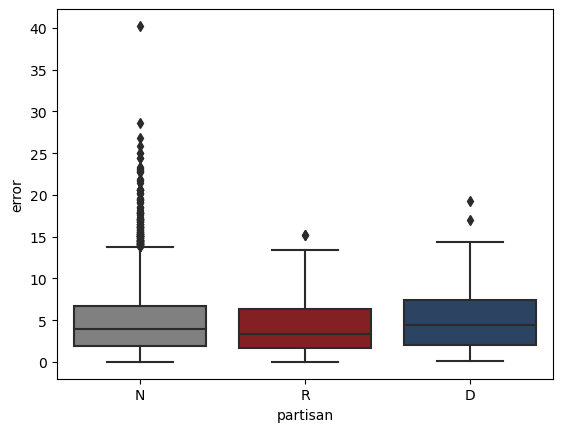

In [43]:
# Create a boxplot for error, using the palette created earlier
sns.boxplot(x = 'partisan', y = 'error', data = filtered_df, palette=my_pal)

<AxesSubplot:xlabel='partisan', ylabel='bias'>

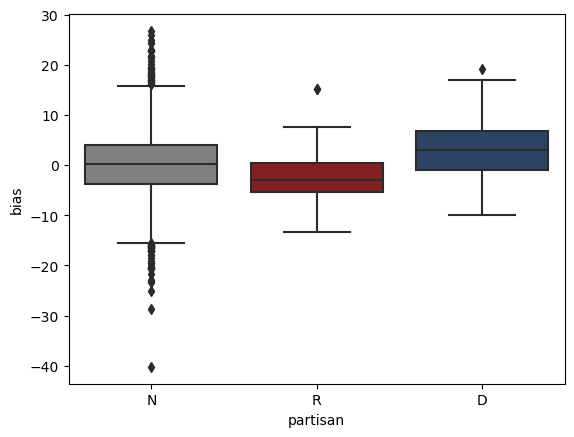

In [44]:
# Create a boxplot for bias, using the palette created earlier
sns.boxplot(x = 'partisan', y = 'bias', data = filtered_df, palette=my_pal)

The median error in partisan polls is not much different from nonpartisan polls. However, their biases are different.

Non-partisan polls have a median bias close to 0. Republican Polls have a bias that leans Republican, and Democratic polls lean towards Democrats. 